# 0. Background - Commodities markets - Tasks

We are interested in **natural gas storage contracts**. The goal is to price the contract using historical data and an estimate of the future gas price at any date. The latter obtained by extrapolating the data available from external feeds. 

## 0.1 Commodity storage contracts
> Commodity storage contracts represent deals between warehouse (storage) and participants in the supply chain (such as refineries, transporters, and distributors).

The deal is an agreement to store an agreed quantity of any physical commodity (oil, natural gas, agriculture) in a warehouse for a specified amount of time. The key terms of such contracts are:

* periodic fees for storage
* limits on withdrawals/injections of commodity

Here, *injection date* refers to the date when the commodity is purchased and stored. 

Firms in commodities trading and hedge funds are interested in these contracts because they could take advantage of **seasonal or intra-day price differentials** in physical commodities.



## 0.2 Tasks

We are asked to follow the following procedure. 

We are given a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. 

> You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

* estimate the purchase price of gas at any date in the past

    * extrapolate it for one year into the future (using the given data)
    (take date as input and return price estimate)

* determine the factors that cause the price of natural gas to vary

# 1. Prep

Load the data

In [1]:
import pandas as pd
import numpy as np 

In [67]:
nat_gas_df = pd.read_csv('./01-nat_gas_historical_data.csv')
nat_gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
nat_gas_df.shape

(48, 2)

The data has two columns: last day of the month and the price. The price is the market price of natural gas delivered at the end of each month. 

In [4]:
nat_gas_df.dtypes

Dates      object
Prices    float64
dtype: object

In [5]:
nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])
nat_gas_df['Dates'].head()

/var/folders/h0/722z94dd3fb0pfv4wg3qmdkh0000gn/T/ipykernel_44296/651607428.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas_df['Dates'] = pd.to_datetime(nat_gas_df['Dates'])


0   2020-10-31
1   2020-11-30
2   2020-12-31
3   2021-01-31
4   2021-02-28
Name: Dates, dtype: datetime64[ns]

In [6]:
nat_gas_df['Dates'].min(), nat_gas_df['Dates'].max()

(Timestamp('2020-10-31 00:00:00'), Timestamp('2024-09-30 00:00:00'))

In [7]:
nat_gas_df['Dates'].min()-nat_gas_df['Dates'].max()

Timedelta('-1430 days +00:00:00')

In [8]:
nat_gas_df.dtypes

Dates     datetime64[ns]
Prices           float64
dtype: object

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df = nat_gas_df.copy()
df.index = df['Dates']
del df['Dates']
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


# 2. Time series analysis 

Before we forecast, we will do a time series analysis (to study the history). When we train a model later, the principle will be

> If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.
>Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

## 2.1 Basics

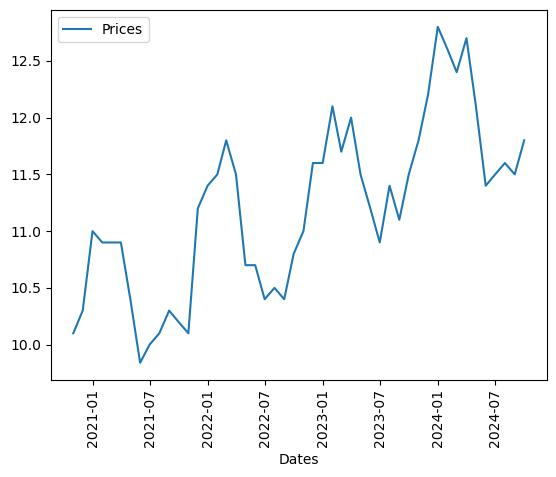

In [70]:
sns.lineplot(df).tick_params(
    axis='x',
    rotation=90
)

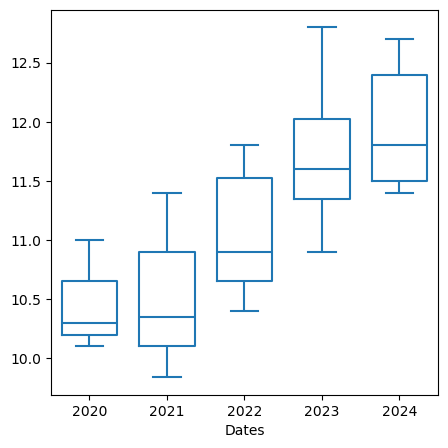

In [43]:
plt.figure(figsize=(5,5))
sns.boxplot(
    x=df.index.year,
    y=df.values[:,0],
    fill=False,
    gap=.1
)
plt.show()

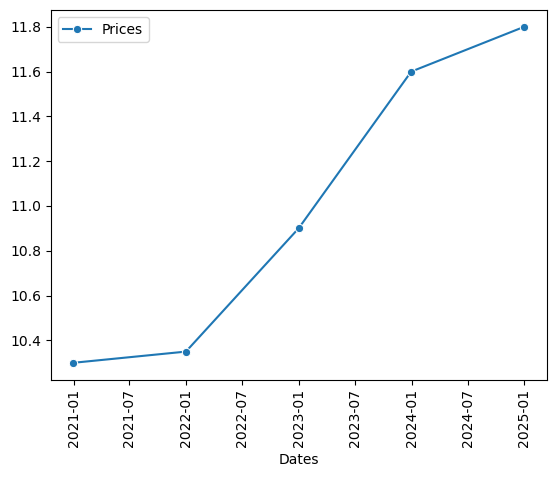

In [65]:
sns.lineplot(
    df.resample('Y').median(),
    marker='o'
).tick_params(
    axis='x', 
    rotation=90
)


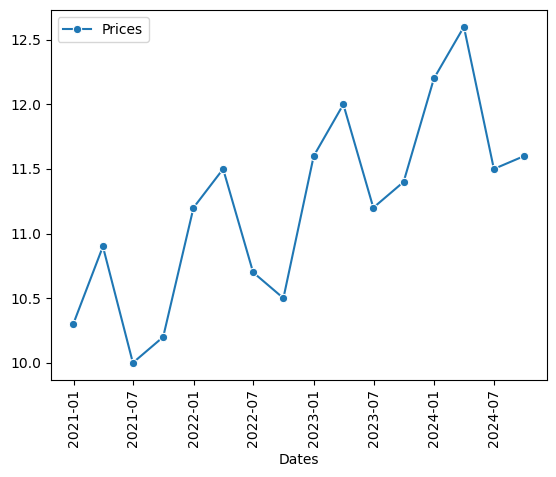

In [69]:
sns.lineplot(
    df.resample('Q').median(),
    marker='o'
).tick_params(
    axis='x', 
    rotation=90
)


## 2.2. Seasonality/Stationarity

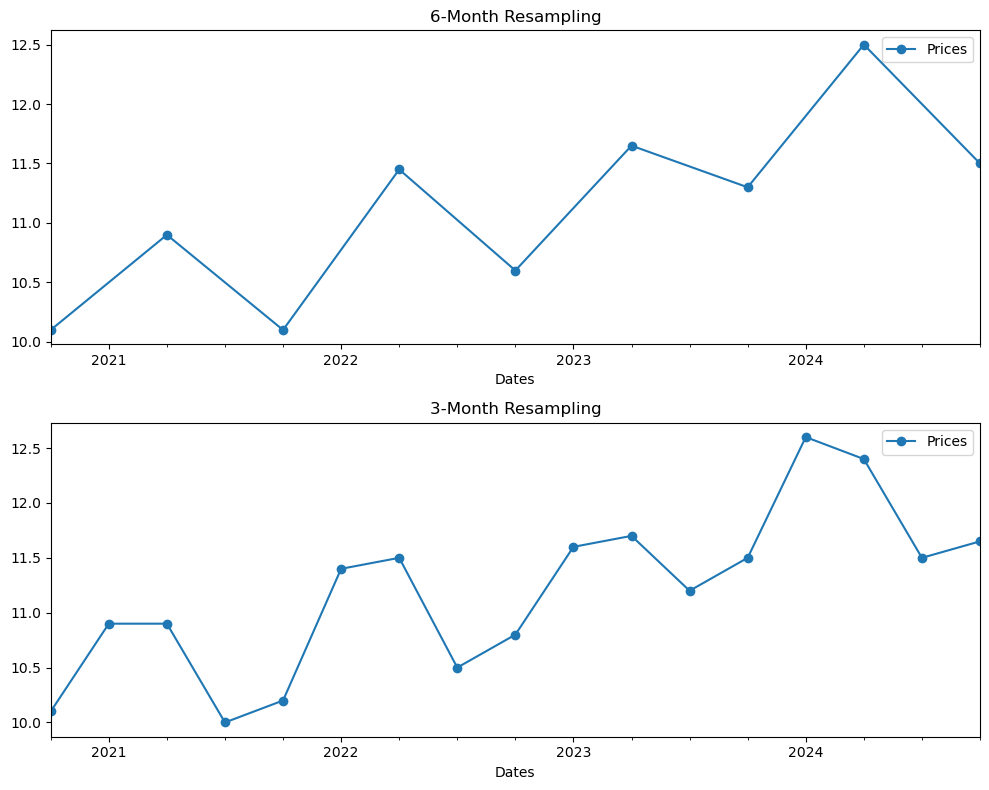

In [176]:
#This is to discover seasonality

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

df.resample('6M').median().plot(style='-o', ax=axes[0])
axes[0].set_title('6-Month Resampling')

df.resample('3M').median().plot(style='-o', ax=axes[1])
axes[1].set_title('3-Month Resampling')

plt.tight_layout()
plt.show()

### 2.2.1 Stationarity

This is our data

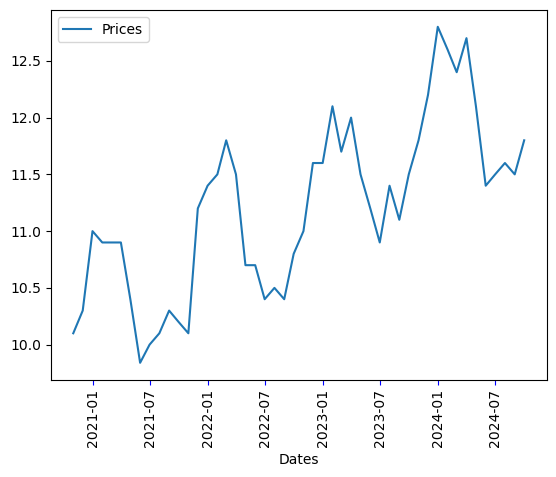

In [71]:
sns.lineplot(df).tick_params(
    axis='x',
    color='blue', 
    rotation=90
)

The extent to which the manner in which time series data changes stays constant. 

* A stationary time series does not show any trends or seasonal patterns 

The null hypothesis: *There is no stationarity.*

The test: (Augmented) **Dickey-Fuller test**, which is a [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

A unit root test determines how closely a time series follows a trend

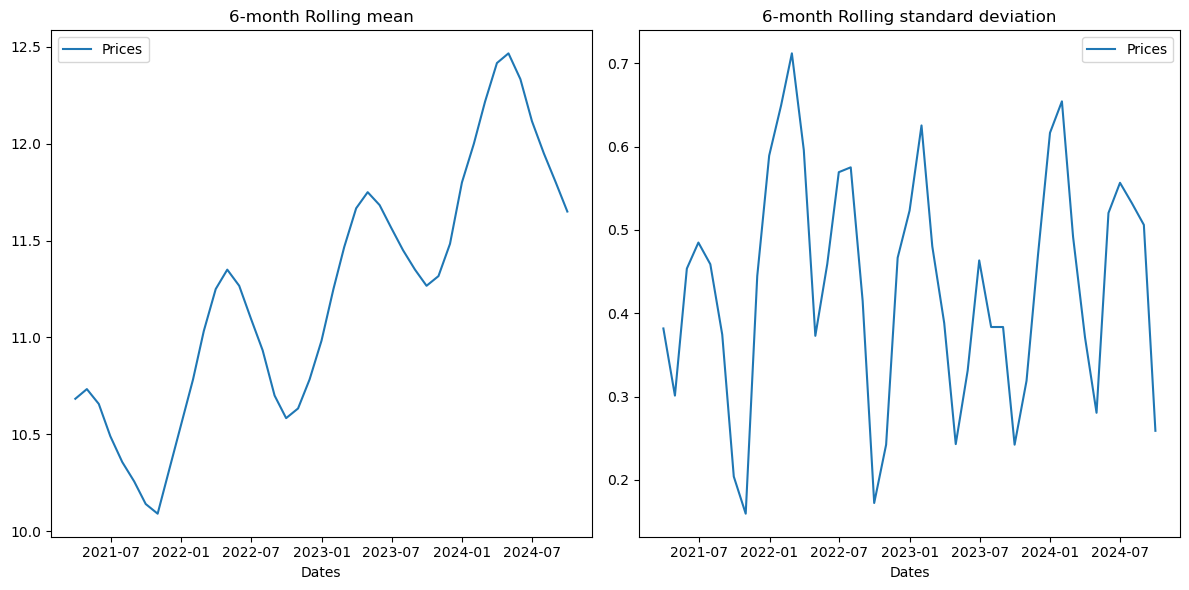

In [31]:
rolling_mean = df.rolling(6).mean() #seven-month rolling mean
rolling_std = df.rolling(6).std() #seven-month rolling std

fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.lineplot(rolling_mean, ax=axes[0])
axes[0].set_title('6-month Rolling mean')

sns.lineplot(rolling_std, ax=axes[1])
axes[1].set_title('6-month Rolling standard deviation')

plt.tight_layout()

In [32]:
pd.merge(pd.merge(df, rolling_mean, on='Dates'),rolling_std, on='Dates').rename(
    columns={
        'Prices_x': 'prices',
        'Prices_y': 'rolling_mean',
        'Prices': 'rolling_std'
    }
).head()

,prices,rolling_mean,rolling_std
Dates,,,
2020-10-31,10.1,NaN,NaN
2020-11-30,10.3,NaN,NaN
2020-12-31,11.0,NaN,NaN
2021-01-31,10.9,NaN,NaN
2021-02-28,10.9,NaN,NaN


In [33]:
df_merged_7 = pd.merge(pd.merge(df, rolling_mean, on='Dates'),rolling_std, on='Dates').rename(
    columns={
        'Prices_x': 'prices',
        'Prices_y': 'rolling_mean',
        'Prices': 'rolling_std'
    }
)

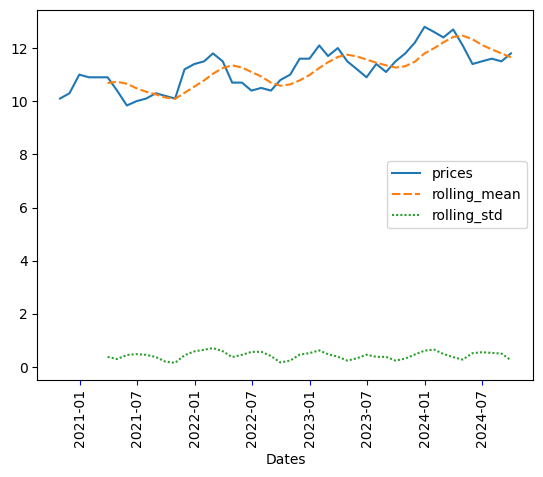

In [72]:
sns.lineplot(df_merged_7).tick_params(
    axis='x',
    color='blue',
    rotation=90)

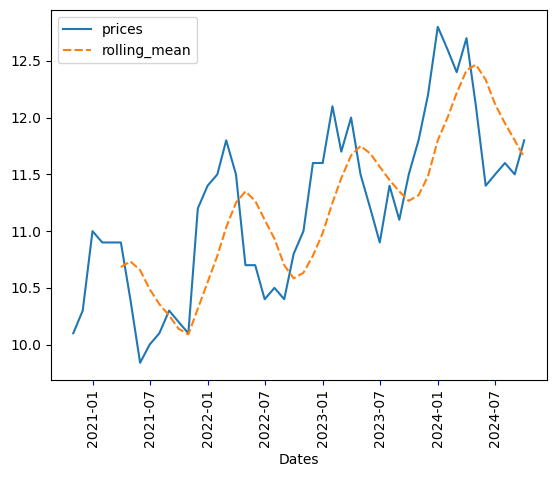

In [73]:
sns.lineplot(
    df_merged_7.drop(columns=['rolling_std'])
).tick_params(
    axis='x', 
    color='blue', 
    rotation=90
)

This suggests that the price data is not stationary. 

In [126]:
df.mean()

Prices    11.207083
dtype: float64

We can remove the trend by performing:

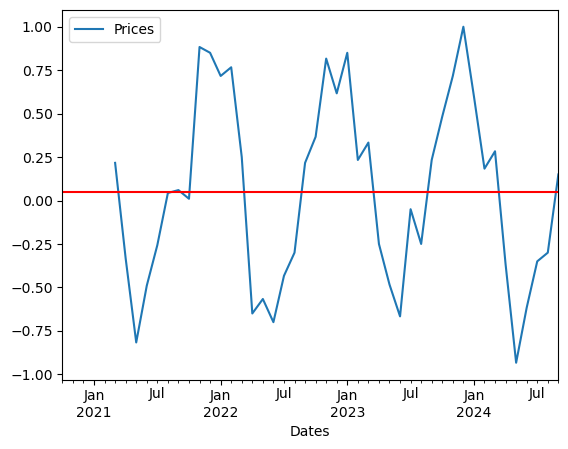

In [158]:
(df - rolling_mean).plot()
plt.axhline(y=df_roll_diff.mean().iloc[0], color='red')



<Axes: xlabel='Dates'>

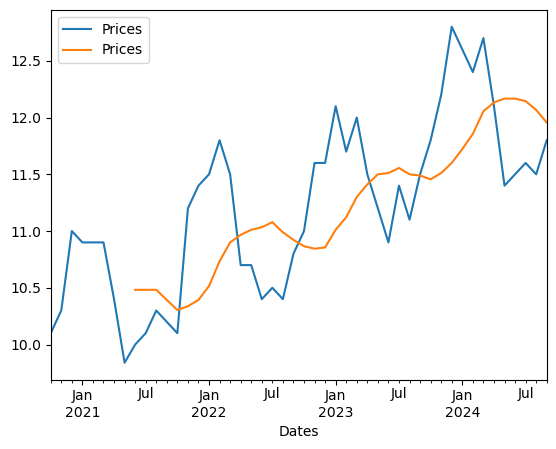

In [170]:
ax = df.plot(label='Prices')
df.rolling(9).mean().plot(ax=ax, label='Rolling Mean')

### 2.2.2 Augmented Dickey-Fuller








The **Null Hypothesis** is that the time series can be represented by a unit root, that it is not stationary (i.e., it has a time-dependent structure). 

* So, the **Alternative Hypothesis** would be that the time series is stationary. 

**H0**: the time series is not stationary. 




If the test fails (to confirm $H_0$), then our time series is stationary. The test fails if the $p$-value is below a threshold (5%). So, if $p$-value $p>0.05$, then the series is not stationary. 

* The more negative the ADE Statistic, the more likely it is that $H_0$ is false. For instance if we get $-4$ while the $5\%$ critical value is $-3.5$, then as $-4<-3.5$, the test fails and we reject $H_0$. That is, the time series is more likely to be stationary. 

In [78]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Prices'])

In [77]:
print(f'ADF Statistic: {result[0]}\
\n      p-value: {result[1]}')

print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF Statistic: 0.21807686169999288
      p-value: 0.9732574388448689
Critical values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


The ADE Statistic is positive and even bigger than the $1\%$ critical value, so we fail to reject the null hypothesis. Hence, our time series is not stationary. You can find a good explanation of the test [here](https://machinelearningmastery.com/time-series-data-stationary-python/). 

## 2.3. Autocorrelation



This is the degree of similarity between a given time series and a lagged version of itself over successive time intervals. 

We want to uncover (more) hiddne patterns in our data to help us select the appropriate forecasting method. If we end up using the ARIMA model, it will help us determine the **AR** parameter represented by $p$. 

<Axes: xlabel='Dates'>

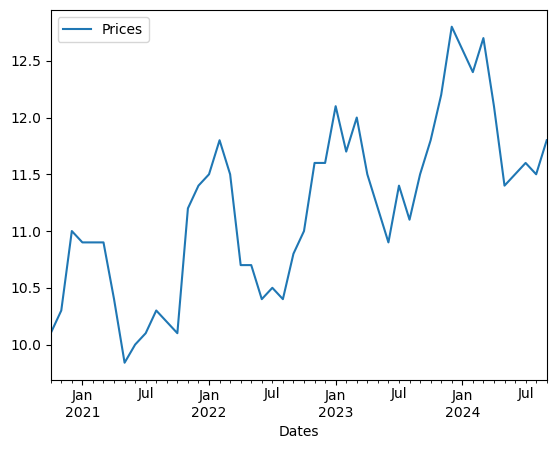

In [80]:
df.plot()

### Differencing

By computing the differences betweeen consecutive observations, we can obtain a stationary time series from a non-stationary one. 

> Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.



Text(0.5, 1.0, 'First-order Differenced')

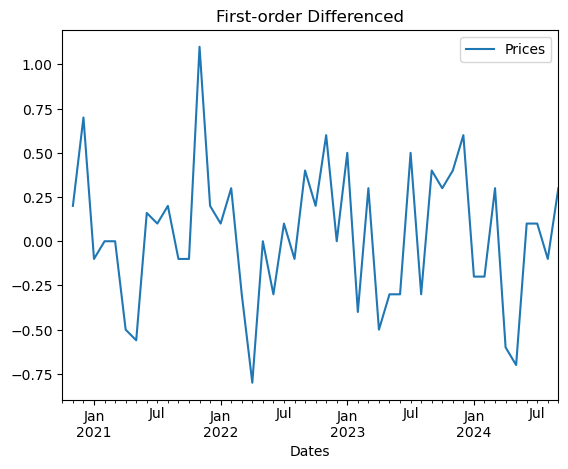

In [125]:
# First-order differencing
df.diff().plot()
plt.title('First-order Differenced')

The first-order differencing has not turned our series into a stationary one since it displays weak seasonality---local min in May, but local max in December.

Let us try second-order differencing:

Text(0.5, 1.0, 'Second-order Differenced')

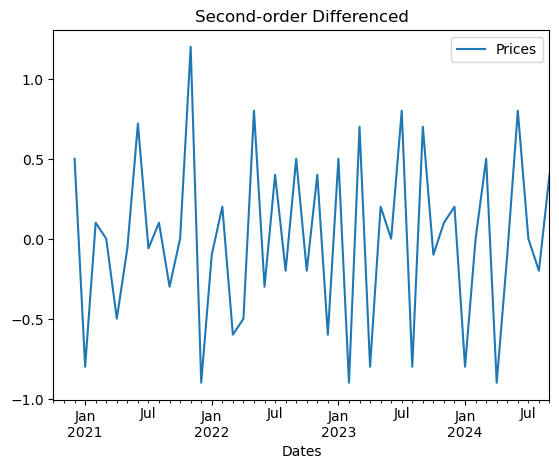

In [112]:
# Second-order differencing
df.diff().diff().plot()
plt.title('Second-order Differenced')

A measure of the linear relationship between observations at different lags.

### Pandas `autocorrelation_plot`

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

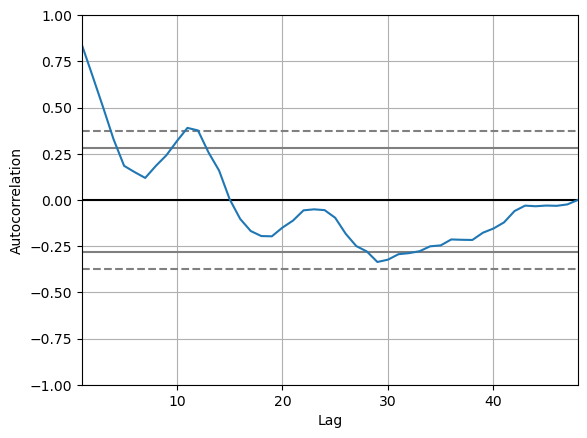

In [81]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df)

There is a positive correlation within the first ~15 lags. 

# 3. Forecasting

##